In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import json
from datetime import datetime, date
from sklearn.model_selection import train_test_split

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical models
import statsmodels.api as sm
from scipy.stats import f
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Data sources
import yfinance as yf
from fredapi import Fred

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

pd.options.display.max_rows = 500
%matplotlib inline 

# Gather Data

In [2]:
api_key = 'b27994ea92311f213e0e709cdd98849b' # hidden
fred = Fred(api_key)

Let's try for a less volatile time period

In [3]:
# Set period
start = datetime(2008, 1, 1)
end = date.today()

# Gather series
vix = fred.get_series('VIXCLS', start, end)
vix_lag_1month = vix.shift(21) # Also add previous values of volatility
interest_rates = fred.get_series('FEDFUNDS', start, end)
gdp = fred.get_series('GDP', start, end)
gdp_growth = gdp.pct_change() * 100
cpi = fred.get_series('CPIAUCSL', start, end)
unemployment = fred.get_series('UNRATE', start, end)
housing_starts = fred.get_series('HOUST', start, end)
home_prices = fred.get_series('CSUSHPINSA', start, end)
usd_idx = yf.download('DX-Y.NYB', start, end)['Adj Close']
corporate_bond_yields = fred.get_series('BAMLC0A4CBBBEY', start, end)
treasury_yields = fred.get_series('DGS10', start, end)

# Gather S&P500 Data
sp500 = yf.download('^GSPC', start=start, end=end)
# Gather Returns in unit percentage
sp500['Returns'] = sp500['Adj Close'].pct_change() * 100
# Gather response variable
squared_returns = np.square(sp500['Returns'])
volatility = np.sqrt(squared_returns.rolling(window=21).sum())
# Logged volatility
log_volatility = np.log(volatility)
# Create 1-month lagged AR term
volatility_lag_1month = log_volatility.shift(21)
# Create 1-week lagged AR term
volatility_lag_1week = log_volatility.shift(5)

# Gather Volume regressor
volume = sp500['Volume']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Combine all macro series into one dataframe
combined_df = pd.concat([
    log_volatility,
    volatility_lag_1week,
    volatility_lag_1month,
    volume, 
    vix_lag_1month,
    interest_rates,
    gdp,
    gdp_growth,
    cpi,
    unemployment,
    housing_starts,
    home_prices,
    usd_idx,
    corporate_bond_yields,
    treasury_yields
], axis=1)

# Set columns
combined_df.columns = [
    "Logged_Volatility",
    "volatility_lag_1week",
    "Volatility_Lag_One_Month",
    "Volume",
    'VIX_Lag_One_Month',
    'Interest_Rates', 
    'GDP', 
    'GDP_Growth',
    'CPI', 
    'Unemployment_Rate', 
    'Housing_Starts', 
    'Home_Prices', 
    'US_Dollar_Index', 
    'Corporate_Bond_Yields', 
    'Ten_Year_Treasury_Yield'
]

combined_df = sm.add_constant(combined_df)
# Forward Fill imputation
combined_df.fillna(method='ffill', inplace=True)
# Let's select from 2000 onwards
combined_df = combined_df[combined_df.index.get_loc('2013-01-01'):combined_df.index.get_loc('2019-01-01')]
# Let's view our dataframe
combined_df.tail(20)

,const,Logged_Volatility,volatility_lag_1week,Volatility_Lag_One_Month,Volume,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
2018-12-04,1.0,1.825741,1.637483,1.919543,4.515710e+09,19.96,2.27,20917.867,0.572809,252.767,3.9,1095.0,204.696,96.970001,4.77,2.91
2018-12-05,1.0,1.825741,1.637483,1.919543,4.515710e+09,19.91,2.27,20917.867,0.572809,252.767,3.9,1095.0,204.696,96.970001,4.77,2.91
2018-12-06,1.0,1.821957,1.721651,1.919630,5.180430e+09,16.36,2.27,20917.867,0.572809,252.767,3.9,1095.0,204.696,96.809998,4.78,2.87
2018-12-07,1.0,1.883935,1.681631,1.923809,4.242240e+09,16.72,2.27,20917.867,0.572809,252.767,3.9,1095.0,204.696,96.510002,4.75,2.85
2018-12-10,1.0,1.829476,1.672725,1.969423,4.162880e+09,17.36,2.27,20917.867,0.572809,252.767,3.9,1095.0,204.696,97.220001,4.77,2.85
2018-12-11,1.0,1.828681,1.674177,1.852151,3.963440e+09,20.45,2.27,20917.867,0.572809,252.767,3.9,1095.0,204.696,97.389999,4.78,2.89
2018-12-12,1.0,1.821502,1.825741,1.808630,4.029300e+09,20.02,2.27,20917.867,0.572809,252.767,3.9,1095.0,204.696,97.040001,4.78,2.91
2018-12-13,1.0,1.767942,1.821957,1.833045,3.978340e+09,21.25,2.27,20917.867,0.572809,252.767,3.9,1095.0,204.696,97.059998,4.76,2.91
2018-12-14,1.0,1.818087,1.883935,1.828850,4.064370e+09,19.98,2.27,20917.867,0.572809,252.767,3.9,1095.0,204.696,97.440002,4.73,2.89
2018-12-17,1.0,1.865120,1.829476,1.773717,4.661420e+09,18.14,2.27,20917.867,0.572809,252.767,3.9,1095.0,204.696,97.099998,4.70,2.86


In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize volume 
combined_df['Volume'] = scaler.fit_transform(combined_df[['Volume']])

# Standardize GDP
combined_df['GDP'] = scaler.fit_transform(combined_df[['GDP']])

# Scale housing starts
combined_df['Housing_Starts'] = scaler.fit_transform(combined_df[['Housing_Starts']])

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Assuming combined_df is your DataFrame and the model formula is defined
formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield'

# Fit the model on the entire dataset
model = smf.ols(formula=formula, data=combined_df).fit()

# Calculate leverage (hat) values
influence = model.get_influence()
leverage = influence.hat_matrix_diag

# Calculate studentized residuals
studentized_residuals = influence.resid_studentized_internal

# Calculate Cook's distance
cooks_d = influence.cooks_distance[0]

# Leverage threshold (commonly used threshold is 2p/n
n = len(combined_df)
p = len(model.params)
leverage_threshold = 2 * p / n

# Outliers based on studentized residuals (commonly used threshold is |t| > 2 for a smaller dataset)
studentized_residuals_threshold = 2

# High Cook's distance threshold (commonly used threshold is 4/n)
cooks_d_threshold = f.ppf(0.5, p, n - p)

# Identify high leverage points, outliers, and high Cook's distance points
high_leverage_points = np.where(leverage > leverage_threshold)[0]
outliers = np.where(np.abs(studentized_residuals) > studentized_residuals_threshold)[0]
high_cooks_d_points = np.where(cooks_d > cooks_d_threshold)[0]

# Combine all identified points
all_indices_to_remove = np.unique(np.concatenate([high_leverage_points, outliers, high_cooks_d_points]))

print(f'Indices to remove: {all_indices_to_remove}')

# Remove the identified points from the dataset
# Convert integer positions to datetime values
indices_to_remove = combined_df.index[all_indices_to_remove]

# Drop rows based on datetime index values
cleaned_df = combined_df.drop(index=indices_to_remove)

print(f'Original dataset size: {combined_df.shape}')
print(f'Cleaned dataset size: {cleaned_df.shape}')

Indices to remove: [  19  125  267  306  313  315  326  477  499  513  514  515  516  517
  518  526  529  530  708  711  712  713  714  715  716  717  718  719
  720  721  722  723  724  725  726  728  729  730  731  735  779  794
  798  799  802  817  831  832  833  834  835  836  837  838  839  840
  842  850  860  932  938  939  941  942  952  953  985  986  987 1032
 1033 1047 1048 1049 1050 1059 1193 1326 1363 1364 1365 1366 1367 1368
 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1380 1381 1382
 1383 1384 1385 1386 1387 1388 1389 1390 1392 1398 1399 1406 1407 1408
 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1530 1532 1535 1537
 1538 1539 1540 1541 1542 1543 1544 1545 1560 1561 1568 1577 1578 1588
 1598 1599 1600 1601]
Original dataset size: (1606, 16)
Cleaned dataset size: (1462, 16)


In [7]:
cleaned_df['Logged_Volatility'].describe()

count    1462.000000
mean        1.072410
std         0.377764
min         0.093089
25%         0.810113
50%         1.044589
75%         1.327851
max         2.204689
Name: Logged_Volatility, dtype: float64

/var/folders/pl/jj87skw96cbcsdl_06122bwr0000gn/T/ipykernel_59354/1732864786.py:53: RuntimeWarning: divide by zero encountered in divide
  zz = np.sqrt(cooks_d_threshold * (1 / xx) * (1 - xx))


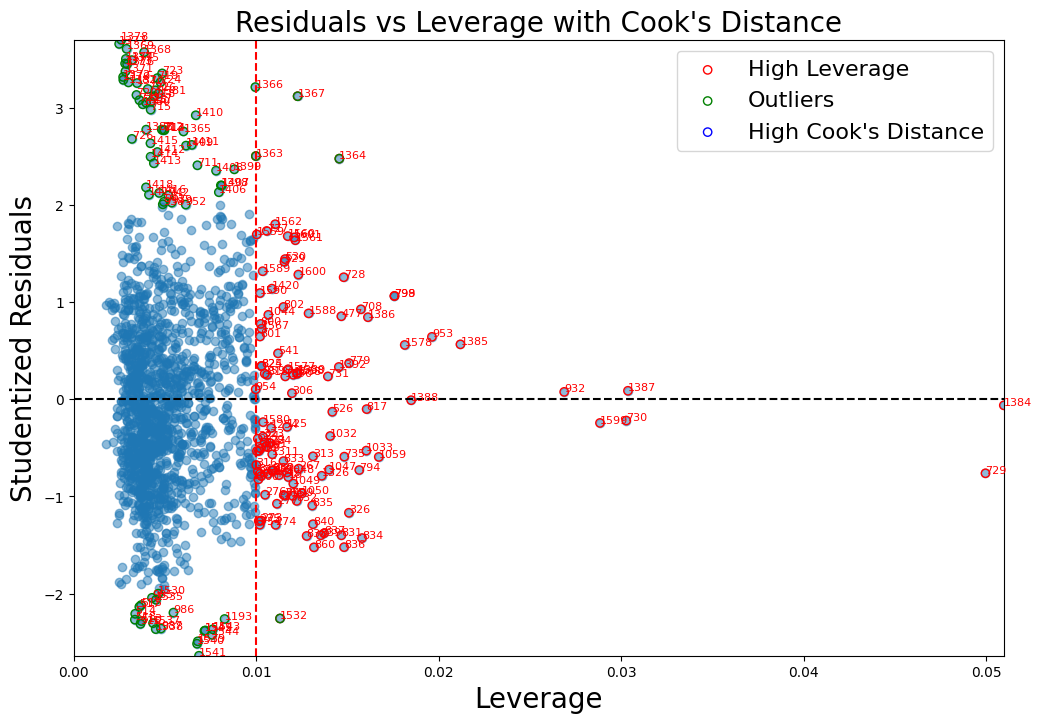

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import f

# Fit the model on the entire dataset
model = smf.ols(formula=formula, data=combined_df).fit()

# Calculate leverage (hat) values
influence = model.get_influence()
leverage = influence.hat_matrix_diag

# Calculate studentized residuals
studentized_residuals = influence.resid_studentized_internal

# Calculate Cook's distance
cooks_d = influence.cooks_distance[0]

# Leverage threshold (commonly used threshold is 2*(p+1)/n, where p is the number of predictors)
n = len(combined_df)
p = len(model.params) - 1
leverage_threshold = 2 * p / n

# Outliers based on studentized residuals (commonly used threshold is |t| > 2)
studentized_residuals_threshold = 2

# High Cook's distance threshold (commonly used threshold is the 50th percentile of F(p, n-p))
cooks_d_threshold = f.ppf(0.5, p, n - p)

# Identify high leverage points, outliers, and high Cook's distance points
high_leverage_points = np.where(leverage > leverage_threshold)[0]
outliers = np.where(np.abs(studentized_residuals) > studentized_residuals_threshold)[0]
high_cooks_d_points = np.where(cooks_d > cooks_d_threshold)[0]

# Combine all identified points
all_influential_points = np.unique(np.concatenate([high_leverage_points, outliers, high_cooks_d_points]))

# Plotting the influential points
plt.figure(figsize=(12, 8))
plt.scatter(leverage, studentized_residuals, alpha=0.5)
plt.scatter(leverage[high_leverage_points], studentized_residuals[high_leverage_points], edgecolor='r', facecolor='none', label='High Leverage')
plt.scatter(leverage[outliers], studentized_residuals[outliers], edgecolor='g', facecolor='none', label='Outliers')
plt.scatter(leverage[high_cooks_d_points], studentized_residuals[high_cooks_d_points], edgecolor='b', facecolor='none', label='High Cook\'s Distance')

# Label the influential points
for i in all_influential_points:
    plt.annotate(i, (leverage[i], studentized_residuals[i]), fontsize=8, color='red')

# Add Cook's distance contours
xx, yy = np.meshgrid(np.linspace(0, max(leverage), 100), np.linspace(min(studentized_residuals), max(studentized_residuals), 100))
zz = np.sqrt(cooks_d_threshold * (1 / xx) * (1 - xx))
plt.contour(xx, yy, zz, levels=[0.5, 1, 1.5], colors='grey', linestyles='--')

plt.axhline(y=0, color='black', linestyle='--')
plt.axvline(x=leverage_threshold, color='red', linestyle='--')
plt.xlabel('Leverage', fontsize = 20)
plt.ylabel('Studentized Residuals',  fontsize = 20)
plt.title('Residuals vs Leverage with Cook\'s Distance',  fontsize = 20)
plt.legend(fontsize=16)
plt.show()

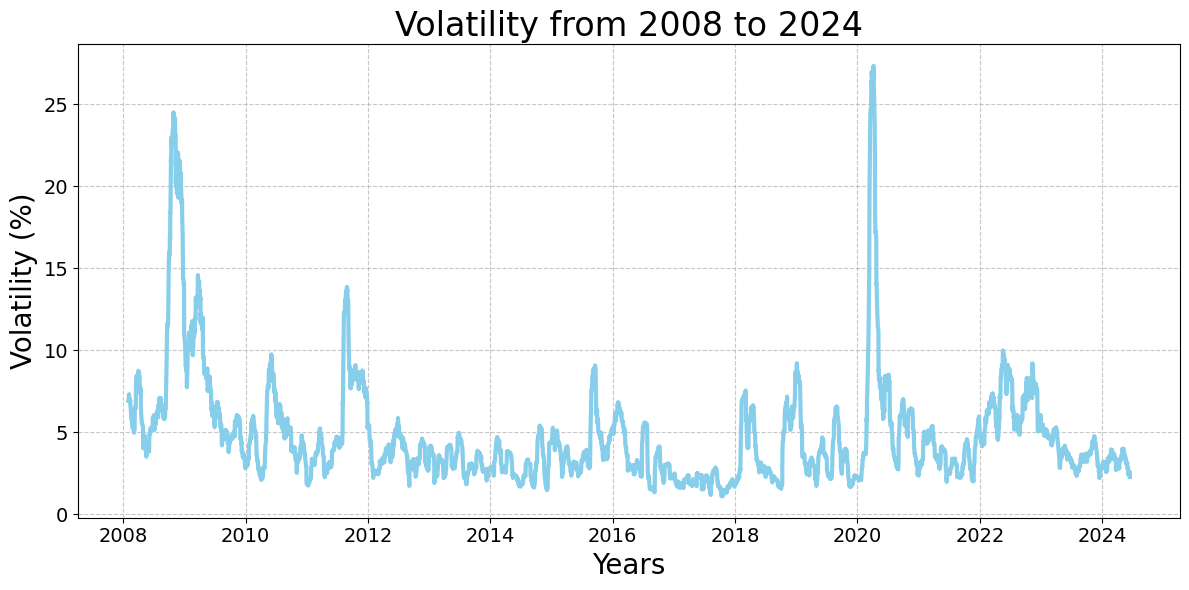

In [9]:
plt.figure(figsize=(12, 6))

# Line plot with customizations
plt.plot(volatility, color='skyblue', linestyle='-', linewidth=3)

# Labels and title
plt.xlabel('Years', fontsize=20)
plt.ylabel('Volatility (%)', fontsize=20)
plt.title('Volatility from 2008 to 2024', fontsize=24)

# Customize ticks and tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Gridlines for better readability
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

# Show plot
plt.show()

In [10]:
combined_df.describe()

,const,Logged_Volatility,volatility_lag_1week,Volatility_Lag_One_Month,Volume,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
count,1606.0,1606.000000,1606.000000,1606.000000,1.606000e+03,1606.000000,1606.000000,1.606000e+03,1606.000000,1606.000000,1606.000000,1.606000e+03,1606.000000,1606.000000,1606.000000,1606.000000
mean,1.0,1.116249,1.114003,1.109024,-1.946692e-16,14.699228,0.593350,2.477609e-15,1.014317,240.485564,5.317372,5.663105e-16,177.717116,91.237098,3.796600,2.351625
std,0.0,0.420295,0.415471,0.409346,1.000311e+00,3.782039,0.655447,1.000311e+00,0.464214,6.148938,1.180333,1.000311e+00,16.520528,7.098266,0.373477,0.409910
min,1.0,0.093089,0.093089,0.093089,-3.210839e+00,9.140000,0.070000,-1.576123e+00,0.033265,231.679000,3.700000,-2.059921e+00,144.310000,79.129997,3.160000,1.370000
25%,1.0,0.820387,0.820807,0.824961,-5.730492e-01,12.292500,0.102500,-6.634672e-01,0.620955,236.222000,4.400000,-7.740205e-01,166.248000,82.792501,3.500000,2.050000
50%,1.0,1.071513,1.071717,1.072899,-1.195625e-01,13.760000,0.240000,-1.653846e-01,1.002751,238.033000,5.000000,2.651665e-01,175.113000,94.080002,3.710000,2.350000
75%,1.0,1.410876,1.411525,1.400830,4.192454e-01,16.105000,1.122500,7.772169e-01,1.345898,244.230500,6.100000,7.137364e-01,193.199750,96.577501,4.040000,2.670000
max,1.0,2.204689,2.204689,2.204689,5.941784e+00,40.740000,2.270000,1.794652e+00,1.865187,252.772000,8.000000,1.842637e+00,205.372000,103.290001,4.830000,3.240000


In [11]:
# Let's view our dataset
combined_df

,const,Logged_Volatility,volatility_lag_1week,Volatility_Lag_One_Month,Volume,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
2013-01-01,1.0,1.168845,1.085843,1.472916,-0.477127,16.64,0.14,-1.576123,1.387114,231.679,8.0,-1.663684,144.310,79.769997,3.33,1.78
2013-01-02,1.0,1.410998,0.982560,1.472917,0.961678,17.12,0.14,-1.576123,1.387114,231.679,8.0,-1.663684,144.310,79.849998,3.36,1.86
2013-01-03,1.0,1.405565,0.995563,1.446789,0.424261,16.46,0.14,-1.576123,1.387114,231.679,8.0,-1.663684,144.310,80.430000,3.37,1.92
2013-01-04,1.0,1.411764,0.977609,1.422667,-0.160099,16.58,0.14,-1.576123,1.387114,231.679,8.0,-1.663684,144.310,80.500000,3.36,1.93
2013-01-07,1.0,1.413910,1.018612,1.422036,-0.332075,15.90,0.14,-1.576123,1.387114,231.679,8.0,-1.663684,144.310,80.260002,3.34,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-25,1.0,1.964023,1.865120,1.838038,-1.328445,18.90,2.27,1.794652,0.572809,252.767,3.9,-0.116118,204.696,96.550003,4.69,2.74
2018-12-26,1.0,2.158567,1.851477,1.707134,1.029621,19.02,2.27,1.794652,0.572809,252.767,3.9,-0.116118,204.696,97.050003,4.74,2.81
2018-12-27,1.0,2.147240,1.879293,1.689447,0.870026,18.49,2.27,1.794652,0.572809,252.767,3.9,-0.116118,204.696,96.480003,4.70,2.77
2018-12-28,1.0,2.146619,1.875991,1.637483,0.278272,18.79,2.27,1.794652,0.572809,252.767,3.9,-0.116118,204.696,96.389999,4.71,2.72


Text(0.5, 0, 'standard deviation of logged returns')

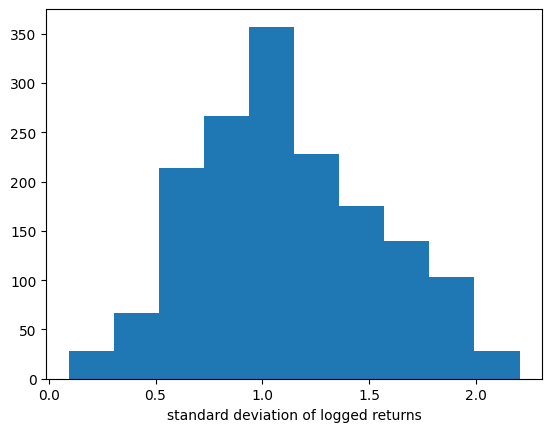

In [12]:
plt.hist(combined_df['Logged_Volatility'])
plt.xlabel("standard deviation of logged returns")

<Figure size 1000x600 with 0 Axes>

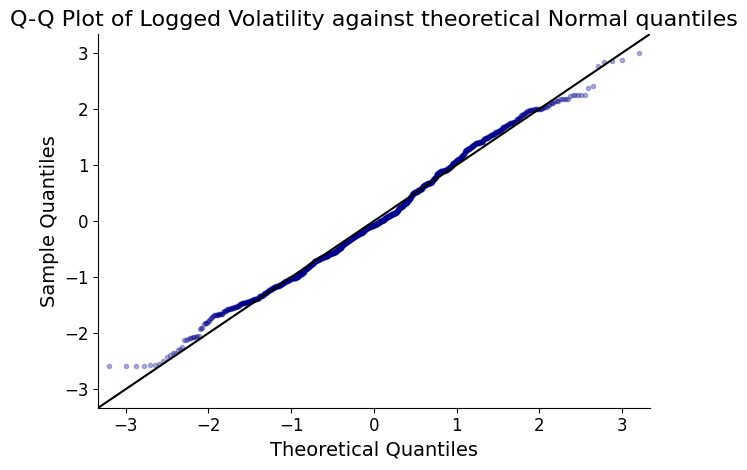

In [13]:
# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Create ProbPlot instance and Q-Q plot
pp = sm.ProbPlot(cleaned_df['Logged_Volatility'], fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='darkblue', markeredgecolor='darkblue', alpha=0.3)

# Add a 45-degree line for reference
sm.qqline(qq.axes[0], line='45', fmt='k--')

# Add title and labels
plt.title("Q-Q Plot of Logged Volatility against theoretical Normal quantiles", fontsize=16)
plt.xlabel("Theoretical Quantiles", fontsize=14)
plt.ylabel("Sample Quantiles", fontsize=14)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Customize ticks and tick labels
plt.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Plot data

In [14]:
# plt.figure(figsize=(7,7))
# plt.plot(gdp, data=combined_df)
# plt.xlabel('Years')
# plt.ylabel('GDP in billions')
# plt.title('US GDP from 2000-2024 in billions')

# Regression

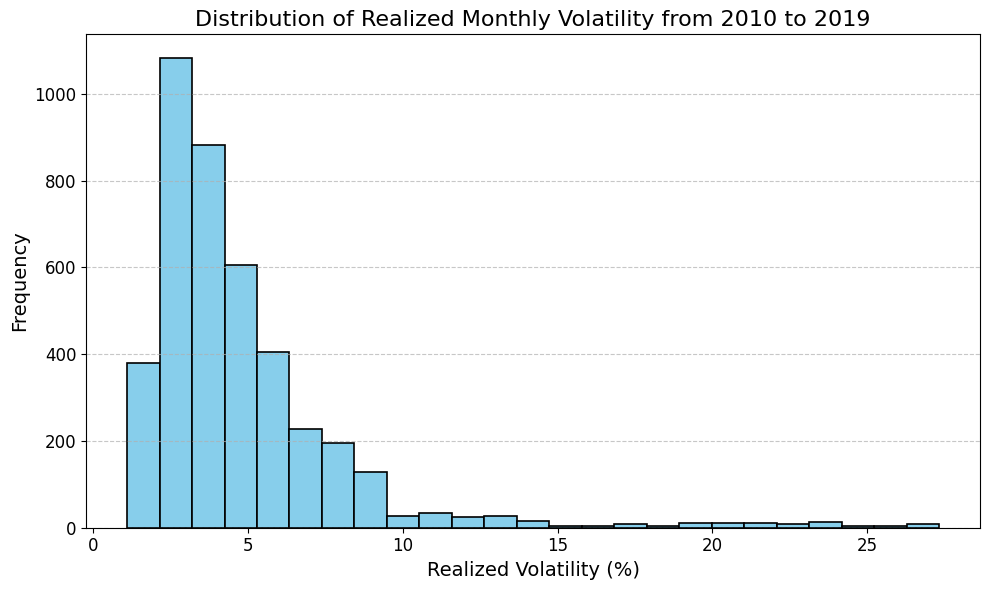

In [15]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot histogram with customizations
plt.hist(volatility, bins=25, color='skyblue', edgecolor='black', linewidth=1.2)

# Add titles and labels
plt.title("Distribution of Realized Monthly Volatility from 2010 to 2019", fontsize=16)
plt.xlabel("Realized Volatility (%)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize ticks and tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a legend if needed
# plt.legend(['Volatility'], loc='best')

# Show plot
plt.tight_layout()  # Adjust spacing to prevent clipping of labels
plt.show()

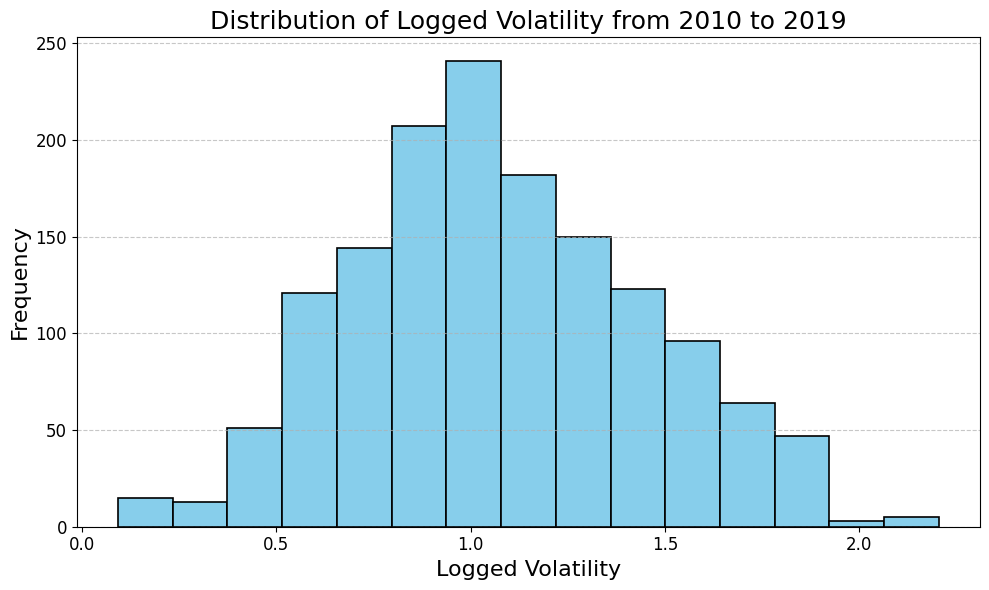

In [16]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot histogram with customizations
plt.hist(cleaned_df['Logged_Volatility'], bins=15, color='skyblue', edgecolor='black', linewidth=1.2)

# Add titles and labels
plt.title("Distribution of Logged Volatility from 2010 to 2019", fontsize=18)
plt.xlabel("Logged Volatility", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize ticks and tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()  # Adjust spacing to prevent clipping of labels
plt.show()

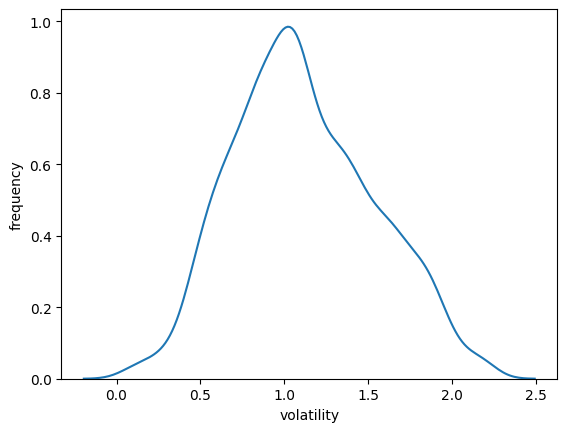

In [17]:
# Histogram of response
sns.kdeplot(combined_df['Logged_Volatility'])
plt.ylabel('frequency')
plt.xlabel('volatility')
plt.show()
# sns.kdeplot(vix)

# Scale & Standardize data

In [18]:
# Test model - here before scaling to demonstrate use of standardization
# Fit the multivariable regression model
test = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP + GDP_Growth + CPI + Unemployment_Rate + Housing_Starts + Home_Prices + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     146.8
Date:                Sun, 16 Jun 2024   Prob (F-statistic):          4.61e-261
Time:                        15:38:06   Log-Likelihood:                -253.51
No. Observations:                1606   AIC:                             535.0
Df Residuals:                    1592   BIC:                             610.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [19]:
print(combined_df.describe())

        const  Logged_Volatility  volatility_lag_1week  \
count  1606.0        1606.000000           1606.000000   
mean      1.0           1.116249              1.114003   
std       0.0           0.420295              0.415471   
min       1.0           0.093089              0.093089   
25%       1.0           0.820387              0.820807   
50%       1.0           1.071513              1.071717   
75%       1.0           1.410876              1.411525   
max       1.0           2.204689              2.204689   

       Volatility_Lag_One_Month        Volume  VIX_Lag_One_Month  \
count               1606.000000  1.606000e+03        1606.000000   
mean                   1.109024 -1.946692e-16          14.699228   
std                    0.409346  1.000311e+00           3.782039   
min                    0.093089 -3.210839e+00           9.140000   
25%                    0.824961 -5.730492e-01          12.292500   
50%                    1.072899 -1.195625e-01          13.760000   
7

In [20]:
# Test model
# Fit the multivariable regression model
test1 = smf.ols(formula = 'Logged_Volatility ~ volatility_lag_1week + VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP + GDP_Growth + CPI + Unemployment_Rate + Home_Prices + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     146.8
Date:                Sun, 16 Jun 2024   Prob (F-statistic):          4.61e-261
Time:                        15:38:06   Log-Likelihood:                -253.51
No. Observations:                1606   AIC:                             535.0
Df Residuals:                    1592   BIC:                             610.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [21]:
# Fit the multivariable regression model - WITHOUT GDP_Growth
test_2 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP + CPI + Unemployment_Rate + Housing_Starts + Home_Prices + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test_2.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     142.3
Date:                Sun, 16 Jun 2024   Prob (F-statistic):          1.08e-241
Time:                        15:38:06   Log-Likelihood:                -301.31
No. Observations:                1606   AIC:                             628.6
Df Residuals:                    1593   BIC:                             698.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [22]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices
test_3 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + Unemployment_Rate + Housing_Starts + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test_3.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     163.2
Date:                Sun, 16 Jun 2024   Prob (F-statistic):          8.84e-236
Time:                        15:38:06   Log-Likelihood:                -320.29
No. Observations:                1606   AIC:                             662.6
Df Residuals:                    1595   BIC:                             721.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [23]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices, Unemployment_Rate
test_4 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test_4.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     200.1
Date:                Sun, 16 Jun 2024   Prob (F-statistic):          1.85e-234
Time:                        15:38:06   Log-Likelihood:                -328.73
No. Observations:                1606   AIC:                             675.5
Df Residuals:                    1597   BIC:                             723.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [24]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices, Housing_Starts, volatility_lag_1week

# Consider using this one; has lowest AIC, all terms significant, and ensures that VIFs are (relatively) low

test_5 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + Unemployment_Rate + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test_5.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     180.3
Date:                Sun, 16 Jun 2024   Prob (F-statistic):          8.62e-236
Time:                        15:38:06   Log-Likelihood:                -322.92
No. Observations:                1606   AIC:                             665.8
Df Residuals:                    1596   BIC:                             719.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [25]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices, Housing_Starts

# Consider using this one; has lowest AIC, all terms significant, and ensures that VIFs are (relatively) low

test_6 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + volatility_lag_1week + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + Unemployment_Rate + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test_6.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     826.1
Date:                Sun, 16 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:38:06   Log-Likelihood:                 576.16
No. Observations:                1606   AIC:                            -1130.
Df Residuals:                    1595   BIC:                            -1071.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

# Outliers

In [26]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices, Housing_Starts - AND WITH INFLUENTIAL POINTS REMOVED

# Consider using this one; has lowest AIC, all terms significant, and ensures that VIFs are (relatively) low

test_7 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + Unemployment_Rate + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=cleaned_df).fit()

# Print the model summary
print(test_7.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     249.3
Date:                Sun, 16 Jun 2024   Prob (F-statistic):          4.37e-287
Time:                        15:38:06   Log-Likelihood:                 32.155
No. Observations:                1462   AIC:                            -44.31
Df Residuals:                    1452   BIC:                             8.565
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [27]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices, Housing_Starts, Unemployment_Rate - AND WITH INFLUENTIAL POINTS REMOVED

# Consider using this one; has lowest AIC, all terms significant, and ensures that VIFs are (relatively) low

test_8 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=train_df).fit()

# Print the model summary
print(test_8.summary())

NameError: name 'train_df' is not defined

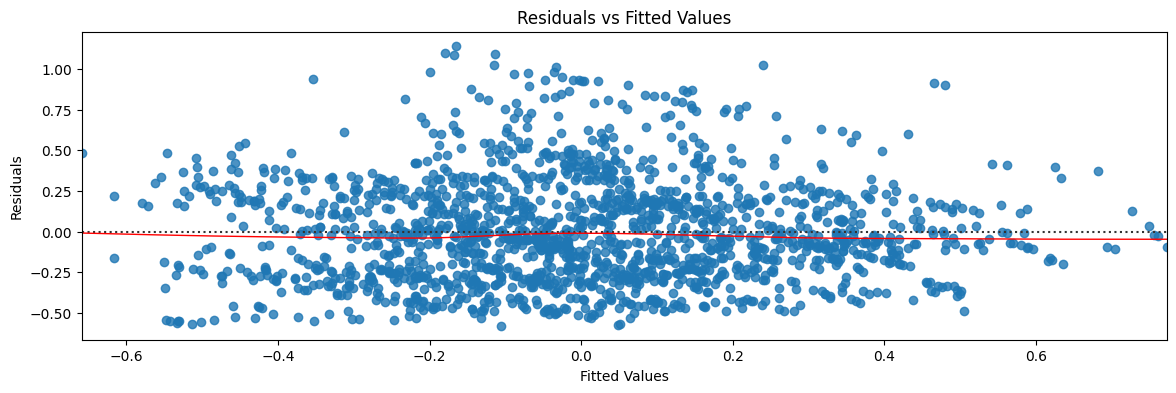

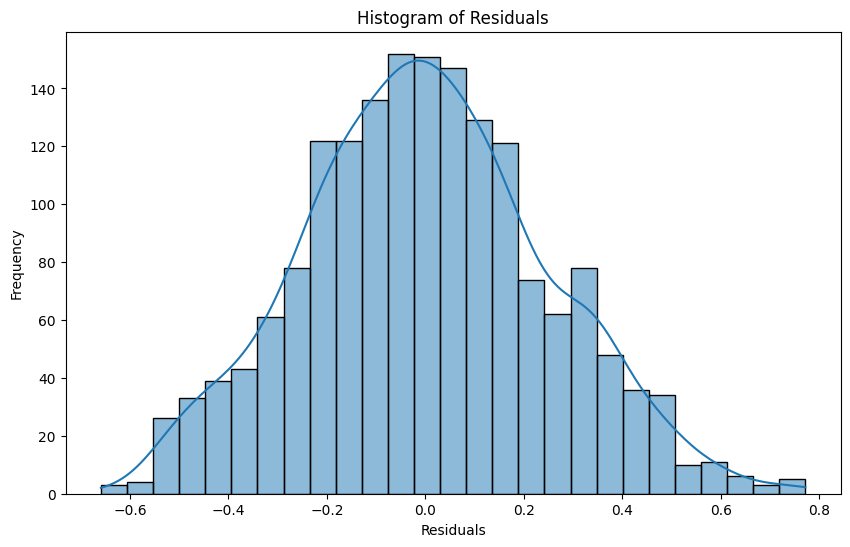

In [ ]:
# Extract residuals and fitted values
resids = test_8.resid
fitted_values = test_8.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(14, 4))
sns.residplot(x=resids, y=fitted_values, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(resids, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

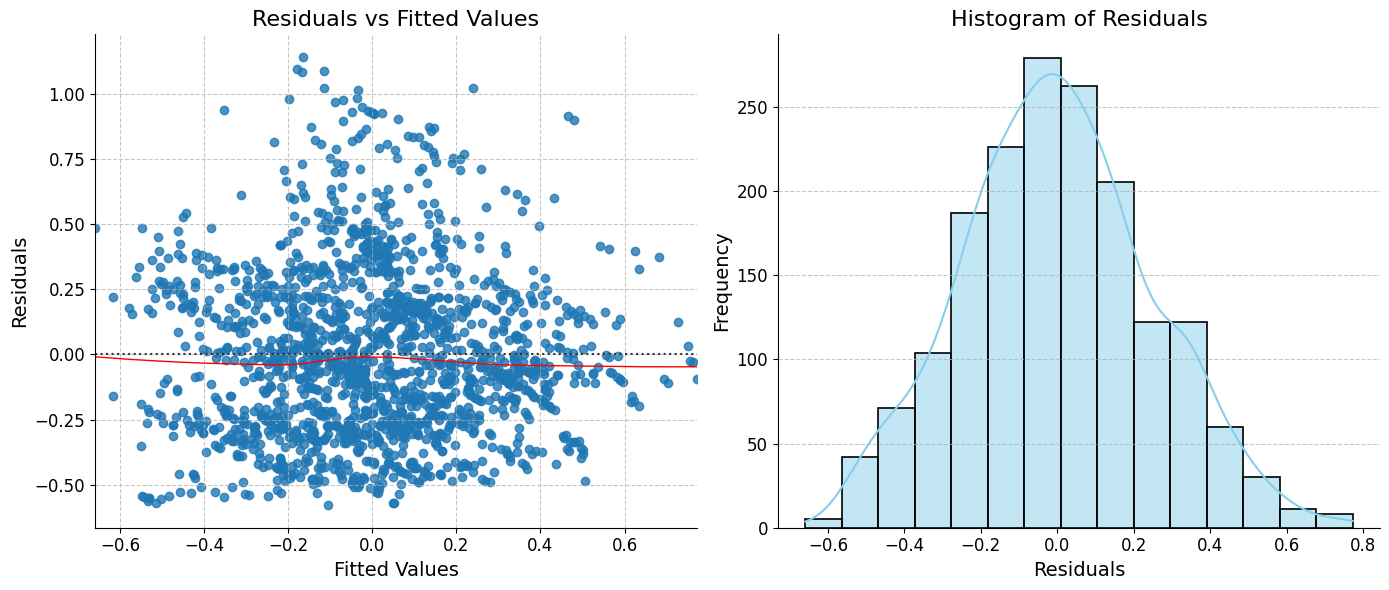

In [ ]:
# Set up the figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

### Plot 1: Residuals vs Fitted Values ###

# Create residual plot with seaborn in subplot 1
sns.residplot(x=resids, y=fitted_values, lowess=True, line_kws={'color': 'red', 'lw': 1}, ax=ax1)

# Customize labels and title for subplot 1
ax1.set_xlabel('Fitted Values', fontsize=14)
ax1.set_ylabel('Residuals', fontsize=14)
ax1.set_title('Residuals vs Fitted Values', fontsize=16)

# Remove top and right spines for subplot 1
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Customize ticks and tick labels for subplot 1
ax1.tick_params(axis='both', which='major', labelsize=12)

# Add gridlines for subplot 1
ax1.grid(axis='both', linestyle='--', alpha=0.7)

### Plot 2: Histogram of Residuals ###

# Create histogram of residuals with KDE plot using seaborn in subplot 2
sns.histplot(resids, bins=15, kde=True, color='skyblue', edgecolor='black', linewidth=1.2, ax=ax2)

# Customize labels and title for subplot 2
ax2.set_xlabel('Residuals', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
ax2.set_title('Histogram of Residuals', fontsize=16)

# Remove top and right spines for subplot 2
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Customize ticks and tick labels for subplot 2
ax2.tick_params(axis='both', which='major', labelsize=12)

# Add gridlines for subplot 2
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show combined plot
plt.show()

<Figure size 1000x600 with 0 Axes>

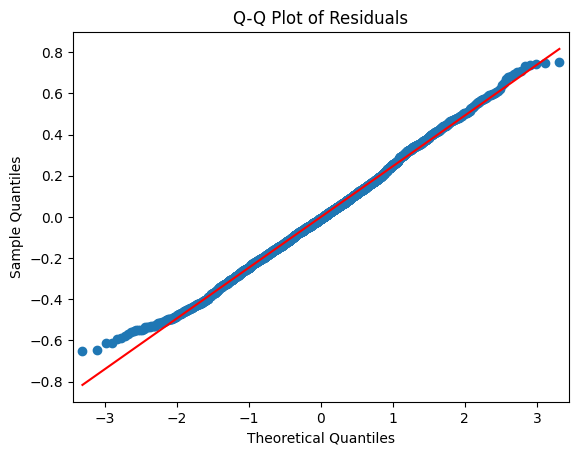

In [ ]:
# Create Q-Q plot of residuals
plt.figure(figsize=(10, 6))
sm.qqplot(resids, line='r')
# stats.probplot(resids, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Multicollinearity

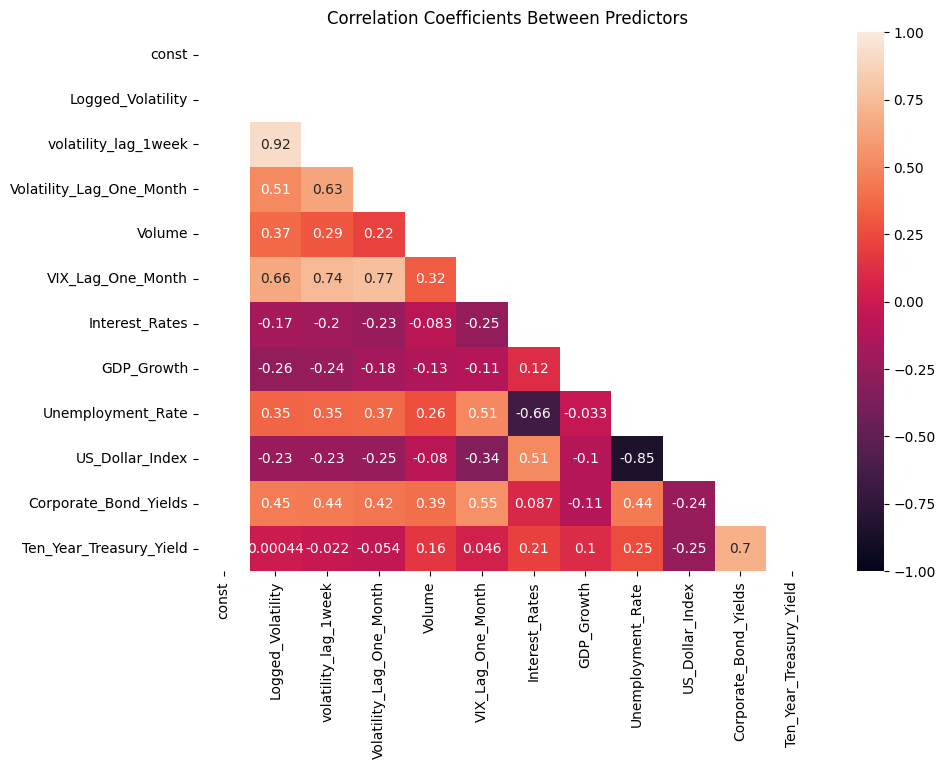

In [ ]:
# Test for multicollinearity - Remove GDP, CPI, Home_Prices, Housing_Starts
plt.figure(figsize=(10,7))
predictors = combined_df.drop(columns=["CPI", 'GDP', 'Home_Prices', 'Housing_Starts'])
mask = np.triu(np.ones_like(predictors.corr(), dtype=bool))
sns.heatmap(predictors.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficients Between Predictors')
plt.show()

# VIF Test

In [ ]:
# VIF test

# Drop the response variable 
X = combined_df.drop(columns=['Logged_Volatility', 'volatility_lag_1week', 'GDP', 'CPI', 'Housing_Starts', 'Home_Prices', 'Unemployment_Rate'])

# Calculate VIF for each explanatory variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                    feature         VIF
0                     const  379.630020
1  Volatility_Lag_One_Month    2.635452
2                    Volume    1.250249
3         VIX_Lag_One_Month    3.561780
4            Interest_Rates    1.724840
5                GDP_Growth    1.156082
6           US_Dollar_Index    1.871245
7     Corporate_Bond_Yields    5.028675
8   Ten_Year_Treasury_Yield    3.673057


# ANOVA

In [ ]:
# ANOVA
anova_result = anova_lm(test_model, train_model)
print(anova_result)

   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0    1726.0  106.811652      0.0       NaN       NaN       NaN
1    1725.0  106.397494      1.0  0.414159  6.714664  0.009643


# Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

# Define the predictors and response
X = combined_df.drop(columns=['Logged_Volatility'])
y = combined_df['Logged_Volatility']

# Fit a Ridge regression model
ridge = Ridge(alpha=1.0)
ridge_scores = cross_val_score(ridge, X, y, cv=5)
print(f'Ridge Regression CV Scores: {ridge_scores.mean()}')

# Fit a Lasso regression model
lasso = Lasso(alpha=0.1)
lasso_scores = cross_val_score(lasso, X, y, cv=5)
print(f'Lasso Regression CV Scores: {lasso_scores.mean()}')

# Plots

In [ ]:
fig, axs  = plt.subplots(2, 2,figsize=(12, 8))
fig.suptitle('US Economic indicators since 2000')

axs[0][0].plot(gdp)
axs[0][0].set_title("Nominal US GDP")
axs[0,0].set_ylabel("$Bn")

In [ ]:
# Create Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Prediction

In [28]:
# TEST PREDICTION

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Step 1: Split the data
train_df, temp_df = train_test_split(cleaned_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 2: Fit the model on training data

formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + GDP_Growth + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield'
test_model = smf.ols(formula=formula, data=train_df).fit()
print(test_model.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     268.4
Date:                Sun, 16 Jun 2024   Prob (F-statistic):          1.66e-237
Time:                        15:38:50   Log-Likelihood:                 35.331
No. Observations:                1169   AIC:                            -54.66
Df Residuals:                    1161   BIC:                            -14.15
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     234.6
Date:                Sun, 16 Jun 2024   Prob (F-statistic):          2.77e-236
Time:                        15:38:58   Log-Likelihood:                 35.349
No. Observations:                1169   AIC:                            -52.70
Df Residuals:                    1160   BIC:                            -7.122
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

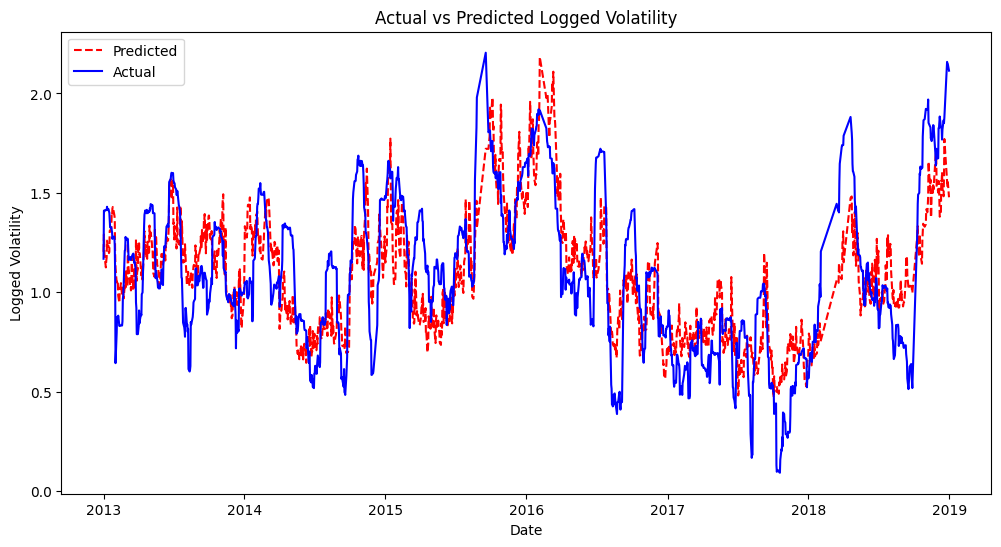

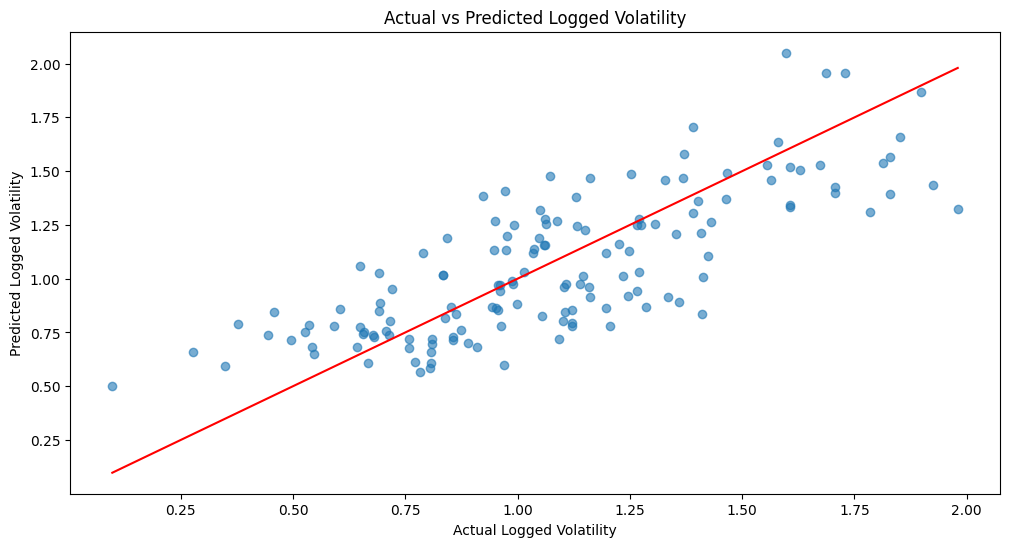

In [29]:
# MAIN PREDICTION

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Step 1: Split the data
train_df, temp_df = train_test_split(cleaned_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 2: Fit the model on training data

formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + GDP_Growth + Interest_Rates + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield'
train_model = smf.ols(formula=formula, data=train_df).fit()
print(train_model.summary())

# Step 3: Validate the model
val_predictions = train_model.predict(val_df)
val_mse = mean_squared_error(val_df['Logged_Volatility'], val_predictions)
print(f'Validation MSE: {val_mse}')

# Step 4: Test the model
test_predictions = train_model.predict(test_df)
test_mse = mean_squared_error(test_df['Logged_Volatility'], test_predictions)
print(f'Test MSE: {test_mse}')

# Calculate baseline MSE
baseline_pred = np.mean(train_df['Logged_Volatility']) # averaging out all logged volatility as a predictive measure
baseline_mse = mean_squared_error(test_df['Logged_Volatility'], [baseline_pred] * len(test_df)) 
print(f'Baseline MSE: {baseline_mse}')

# Predict on the entire dataset for visualization
all_predictions = train_model.predict(cleaned_df)
all_true_values = cleaned_df['Logged_Volatility']  # Assuming 'Logged_Volatility' is the target column
all_mse = mean_squared_error(all_true_values, all_predictions)
print(f'Entire Dataset MSE: {all_mse}')

# Line plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(cleaned_df.index, all_predictions, label='Predicted', color='red', linestyle='--')
plt.plot(cleaned_df.index, cleaned_df['Logged_Volatility'], label='Actual', color='blue')
plt.xlabel('Date')
plt.ylabel('Logged Volatility')
plt.title('Actual vs Predicted Logged Volatility')
plt.legend()
plt.show()

# Scatter plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.scatter(test_df['Logged_Volatility'], test_predictions, alpha=0.6)
plt.plot([min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], [min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], color='red')  # Line of perfect prediction
plt.xlabel('Actual Logged Volatility')
plt.ylabel('Predicted Logged Volatility')
plt.title('Actual vs Predicted Logged Volatility')
plt.show()

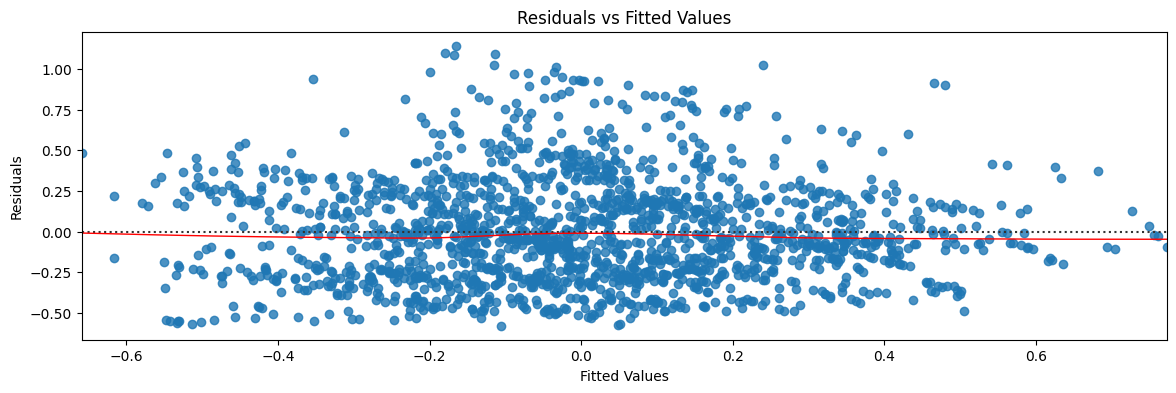

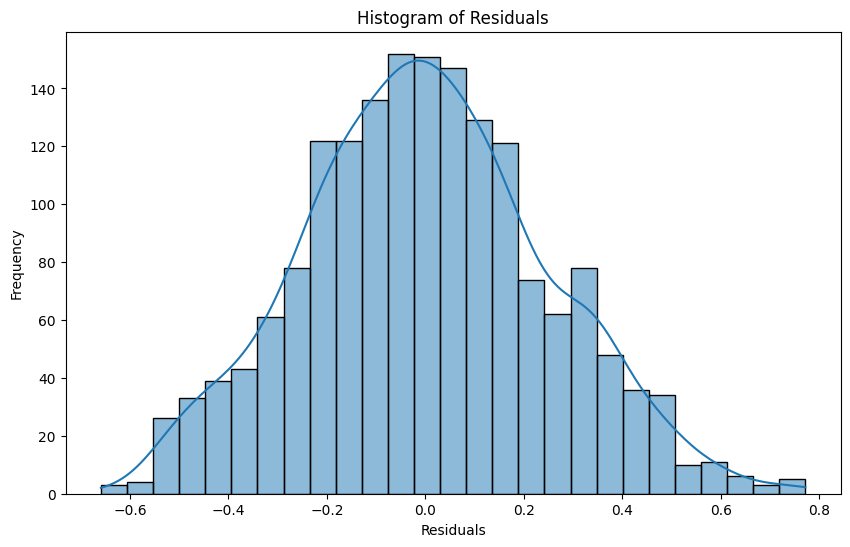

In [ ]:
# Extract residuals and fitted values
resids = train_model.resid
fitted_values = train_model.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(14, 4))
sns.residplot(x=resids, y=fitted_values, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(resids, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

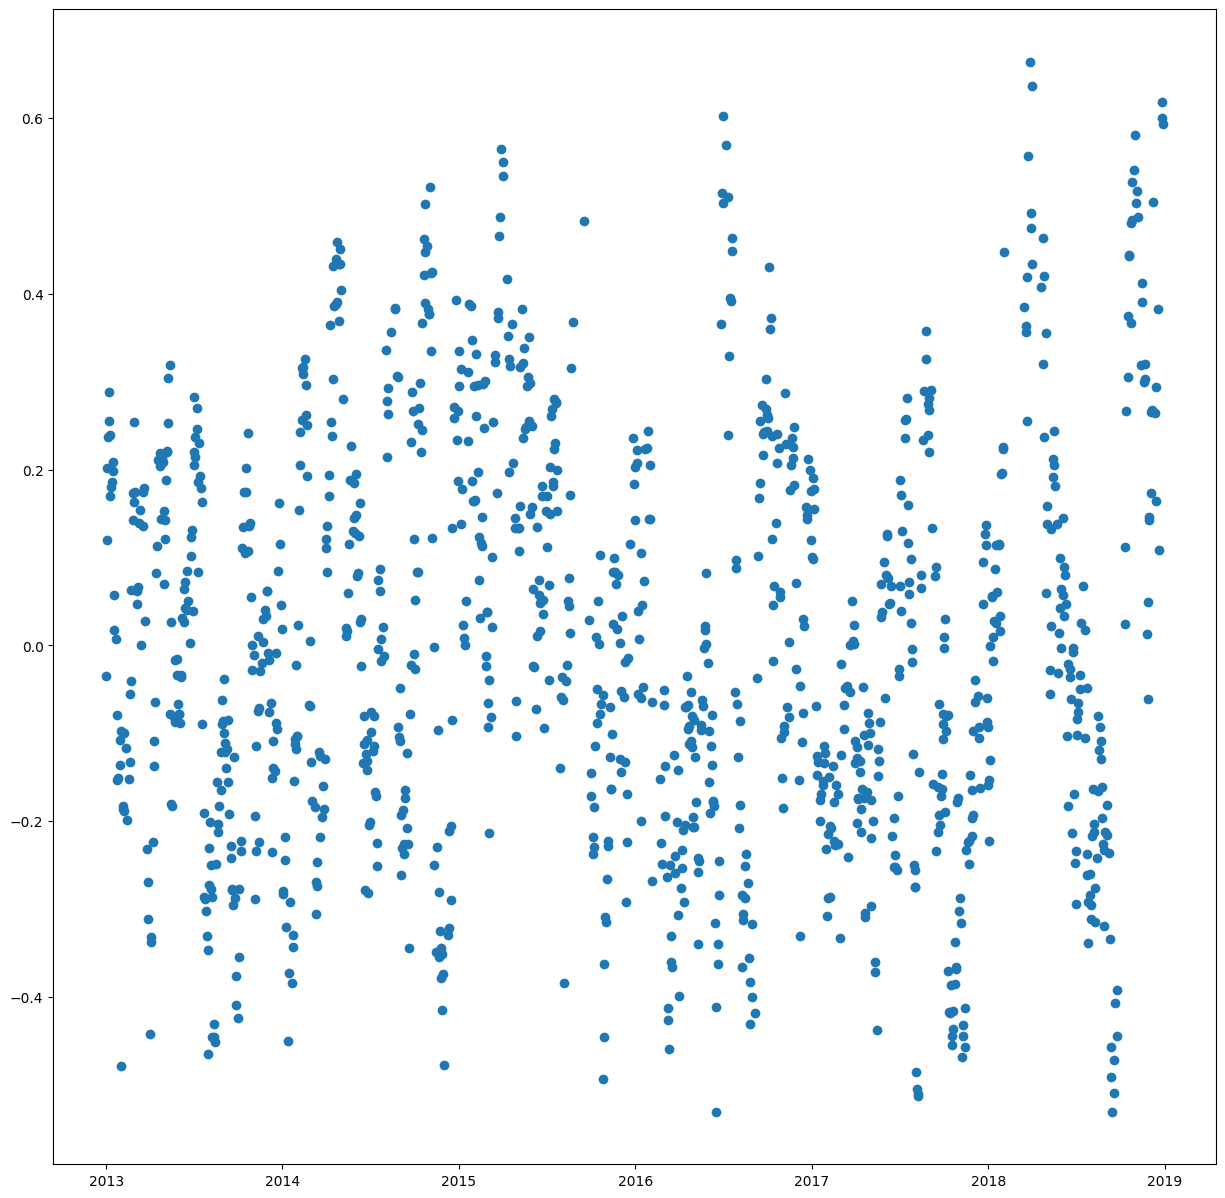

In [32]:
plt.figure(figsize=(15,15))
plt.scatter(train_df.index, train_model.resid)

Overfitted model:

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     270.2
Date:                Sat, 15 Jun 2024   Prob (F-statistic):          1.03e-307
Time:                        21:54:49   Log-Likelihood:                -457.62
No. Observations:                1927   AIC:                             933.2
Df Residuals:                    1918   BIC:                             983.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

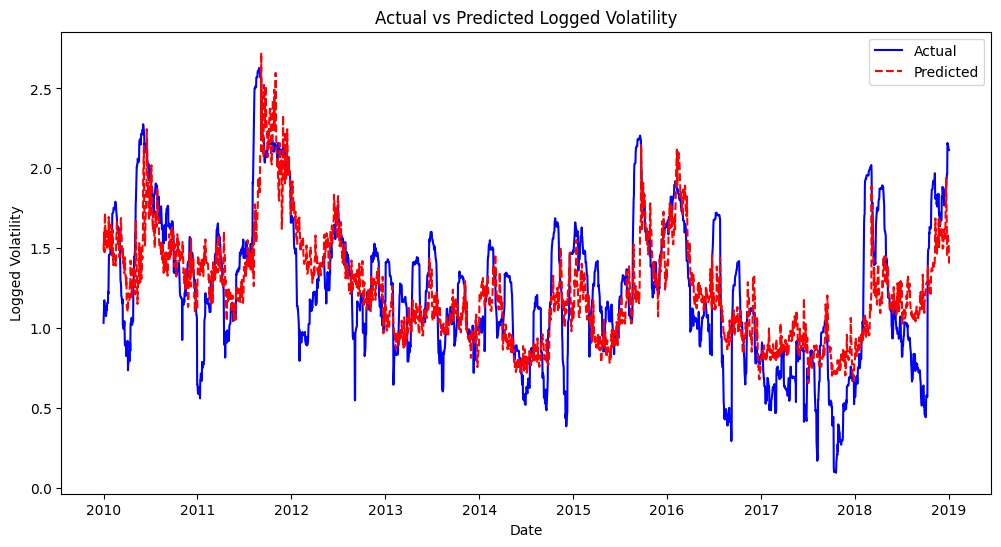

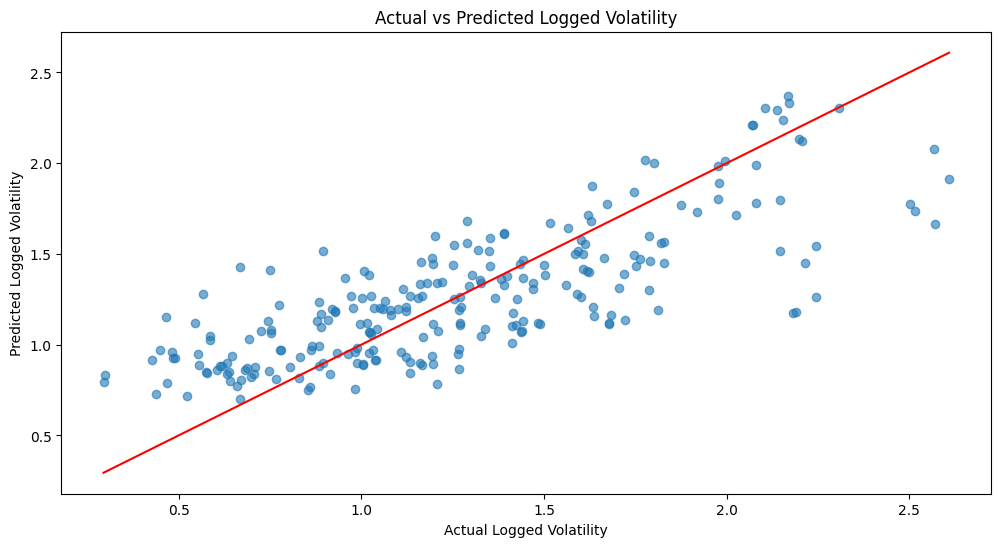

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Step 1: Split the data
train_df, temp_df = train_test_split(combined_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 2: Fit the model on training data
formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + GDP_Growth + Unemployment_Rate + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield'
train_model = smf.ols(formula=formula, data=train_df).fit()
print(train_model.summary())

# Step 3: Validate the model
val_predictions = train_model.predict(val_df)
val_mse = mean_squared_error(val_df['Logged_Volatility'], val_predictions)
print(f'Validation MSE: {val_mse}')

# Step 4: Test the model
test_predictions = train_model.predict(test_df)
test_mse = mean_squared_error(test_df['Logged_Volatility'], test_predictions)
print(f'Test MSE: {test_mse}')

# Predict on the entire dataset for visualization
all_predictions = train_model.predict(combined_df)

# Line plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Logged_Volatility'], label='Actual', color='blue')
plt.plot(combined_df.index, all_predictions, label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Logged Volatility')
plt.title('Actual vs Predicted Logged Volatility')
plt.legend()
plt.show()

# Scatter plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.scatter(test_df['Logged_Volatility'], test_predictions, alpha=0.6)
plt.plot([min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], [min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], color='red')  # Line of perfect prediction
plt.xlabel('Actual Logged Volatility')
plt.ylabel('Predicted Logged Volatility')
plt.title('Actual vs Predicted Logged Volatility')
plt.show()

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     2788.
Date:                Sat, 15 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:51:48   Log-Likelihood:                 1211.0
No. Observations:                1743   AIC:                            -2406.
Df Residuals:                    1735   BIC:                            -2362.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

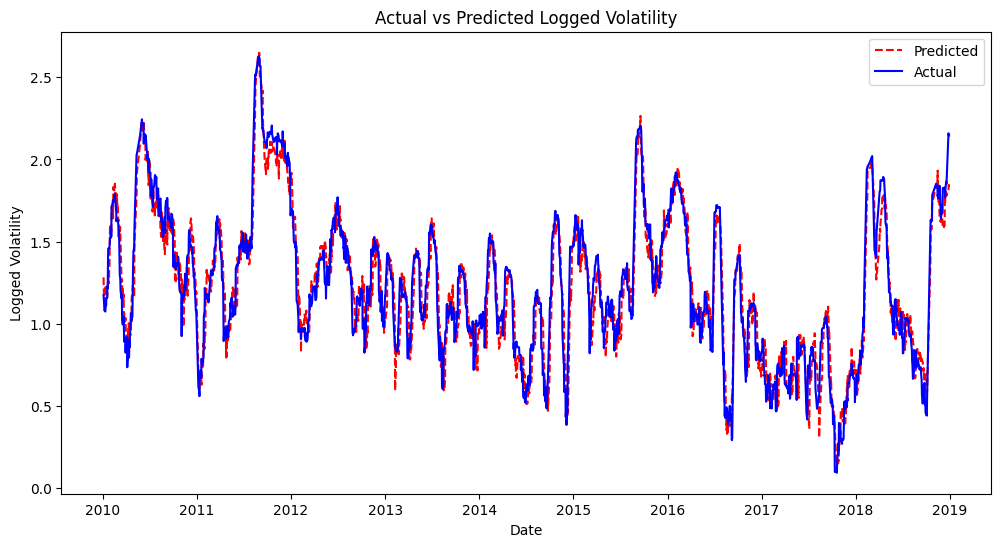

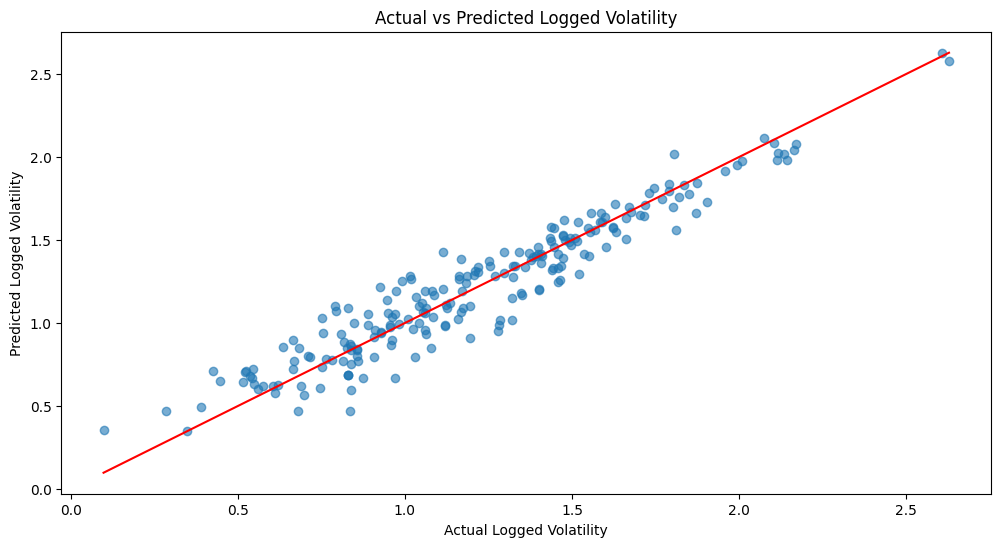

In [ ]:
# TEST PREDICTION

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Step 1: Split the data
train_df, temp_df = train_test_split(cleaned_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 2: Fit the model on training data

formula = 'Logged_Volatility ~ VIX_Lag_One_Month + volatility_lag_1week + Volatility_Lag_One_Month + Volume + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield'
train_model = smf.ols(formula=formula, data=train_df).fit()
print(train_model.summary())

# Step 3: Validate the model
val_predictions = train_model.predict(val_df)
val_mse = mean_squared_error(val_df['Logged_Volatility'], val_predictions)
print(f'Validation MSE: {val_mse}')

# Step 4: Test the model
test_predictions = train_model.predict(test_df)
test_mse = mean_squared_error(test_df['Logged_Volatility'], test_predictions)
print(f'Test MSE: {test_mse}')

# Calculate baseline MSE
baseline_pred = np.mean(train_df['Logged_Volatility']) # averaging out all logged volatility as a predictive measure
baseline_mse = mean_squared_error(test_df['Logged_Volatility'], [baseline_pred] * len(test_df)) 
print(f'Baseline MSE: {baseline_mse}')

# Predict on the entire dataset for visualization
all_predictions = train_model.predict(cleaned_df)
all_true_values = cleaned_df['Logged_Volatility']  # Assuming 'Logged_Volatility' is the target column
all_mse = mean_squared_error(all_true_values, all_predictions)
print(f'Entire Dataset MSE: {all_mse}')

# Line plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(cleaned_df.index, all_predictions, label='Predicted', color='red', linestyle='--')
plt.plot(cleaned_df.index, cleaned_df['Logged_Volatility'], label='Actual', color='blue')
plt.xlabel('Date')
plt.ylabel('Logged Volatility')
plt.title('Actual vs Predicted Logged Volatility')
plt.legend()
plt.show()

# Scatter plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.scatter(test_df['Logged_Volatility'], test_predictions, alpha=0.6)
plt.plot([min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], [min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], color='red')  # Line of perfect prediction
plt.xlabel('Actual Logged Volatility')
plt.ylabel('Predicted Logged Volatility')
plt.title('Actual vs Predicted Logged Volatility')
plt.show()

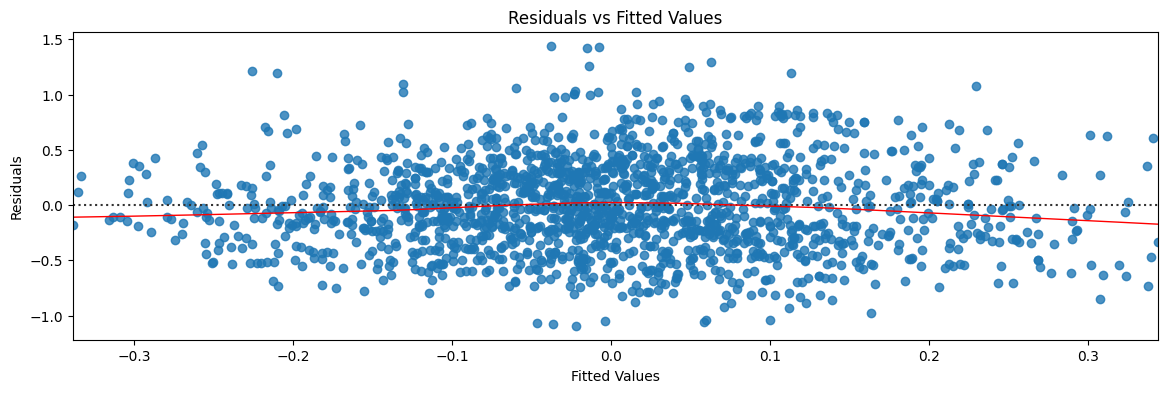

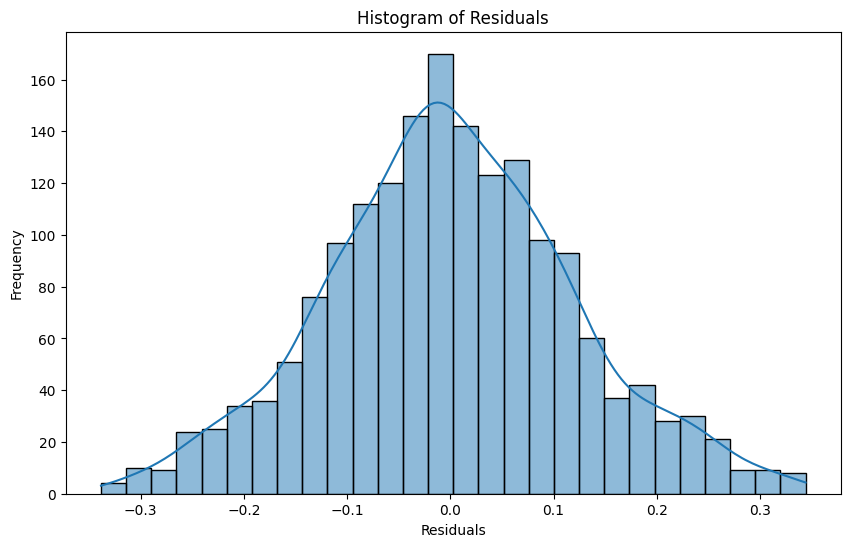

In [ ]:
# Extract residuals and fitted values
resids = train_model.resid
fitted_values = train_model.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(14, 4))
sns.residplot(x=resids, y=fitted_values, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(resids, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()